In [15]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

In [16]:
dataset = pd.read_csv('NHANES.csv')
dataset.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [17]:
dataset["SMQ020x"] = dataset.SMQ020.replace({1:'Yes',2:'No',7:np.nan,9:np.nan})
dataset["RIAGENDRx"] = dataset.RIAGENDR.replace({1:"Male",2:"Female"})
dataset.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210,SMQ020x,RIAGENDRx
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0,Yes,Male
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN,Yes,Male
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0,Yes,Male
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0,No,Female
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0,No,Female


In [25]:
pd.crosstab(dataset.SMQ020x , dataset.RIAGENDRx)

RIAGENDRx,Female,Male
SMQ020x,,
No,2066,1340
Yes,906,1413


In [26]:
dx = dataset.groupby("RIAGENDRx").agg({"SMQ020x" :[lambda x: np.mean(x == 'Yes') , np.size]})
dx.columns = ['Proportion','Total n']
dx

,Proportion,Total n
RIAGENDRx,,
Female,0.304435,2976
Male,0.512142,2759


In [27]:
# Find a confidence interval for females
female_prop = dx.Proportion.Female
n_female = dx["Total n"].Female
se_female = np.sqrt(female_prop*(1-female_prop)/n_female)

lcb = female_prop - 1.9 * se_female
ucb = female_prop + 1.96 * se_female
(lcb,ucb)

(0.28840843791564597, 0.3209686470669839)

In [28]:
# Find a confidence interval for Males
Male_prop = dx.Proportion.Male
n_Male = dx["Total n"].Male
se_Male = np.sqrt(female_prop*(1-Male_prop)/n_Male)

lcb = Male_prop - 1.9 * se_Male
ucb = Male_prop + 1.96 * se_Male
(lcb,ucb)

(0.4982017822039597, 0.5265225986689644)

In [31]:
#Find the difference in proportion for these two above populations

prop_diff = Male_prop - female_prop
se_diff = np.sqrt(se_female**2 + se_male**2)
lcb = prop_diff - 2*se_diff
ucb = prop_diff + 2*se_diff
(lcb,ucb)

(0.18227329737352263, 0.2331398958124142)

In [33]:
sm.stats.proportion_confint(n_Male*Male_prop,n_Male)

(0.49349056386167417, 0.5307935970661982)

In [34]:
sm.stats.proportion_confint(n_female*female_prop,n_female)

(0.2879026244757051, 0.3209683432662304)

### Confidence intervals for subpopulations

Since smoking rates vary strongly with age, it might be more informative to stratify the data into homogeneous age bands and compare the proportions of female and male smokers within each age band.  We can also calculate the 95% confidence interval for this difference within each age band.  These data can be displayed as a plot, with the difference in proportions plotted as a curve.  The confidence intervals can then be used to construct a "confidence band" around the estimates.

In [115]:
dataset["agegrp"]  = pd.cut(dataset.RIDAGEYR , [18,30,40,50,60,70,80])

#Proportion
dx = dataset.groupby(["agegrp","RIAGENDRx"]).agg({"SMQ020x":lambda x: np.mean(x == 'Yes')}).unstack()
dx.columns = ["Female","Male"]
prop_diff = dx.Female - dx.Male
#Total size
dn = dataset.groupby(['agegrp','RIAGENDRx']).agg({"SMQ020x":np.size}).unstack()
dn.columns = ['Female','Male']



#Standard error
se = np.sqrt(dx*(1-dx)/dn)
se_diff = np.sqrt(se.Female**2 + se.Male**2)

lcb = prop_diff - 1.96*se_diff
ucb = prop_diff + 1.96*se_diff

print('lcb\n {} \n\n ucb\n {}'.format(lcb,ucb))
type(lcb)

lcb
 agegrp
(18, 30]   -0.174726
(30, 40]   -0.276542
(40, 50]   -0.242199
(50, 60]   -0.215156
(60, 70]   -0.343777
(70, 80]   -0.389899
dtype: float64 

 ucb
 agegrp
(18, 30]   -0.070601
(30, 40]   -0.153985
(40, 50]   -0.117708
(50, 60]   -0.087665
(60, 70]   -0.216848
(70, 80]   -0.259828
dtype: float64


pandas.core.series.Series

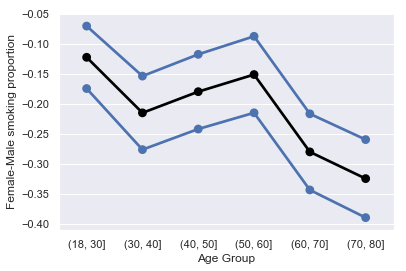

In [119]:
#PLotting the difference

x = np.arange(prop_diff.size)
pp = sns.pointplot(x , prop_diff.values , color = 'black')
sns.pointplot(x , lcb.values)
sns.pointplot(x , ucb.values).set(xlabel = 'Age Group',ylabel = 'Female-Male smoking proportion')
pp.set_xticklabels(dx.index)


plt.show()

### Confidence Intervals for mean


In [79]:
dx = dataset.groupby(["RIAGENDRx"]).agg({'BMXBMI':[np.mean,np.std,np.size]})
dx.columns = ['Mean','Std','Size']
dx

,Mean,Std,Size
RIAGENDRx,,,
Female,29.939946,7.753319,2976.0
Male,28.778072,6.252568,2759.0


In [80]:
se_female = dx.Std.Female/np.sqrt(dx.Size.Female)
se_male = dx.Std.Male/np.sqrt(dx.Size.Male)
(se_female,se_male)

(0.14212522940758335, 0.11903715722332033)

In [83]:
lcb_female = dx.Mean.Female - 1.96*se_female
ucb_female = dx.Mean.Female + 1.96*se_male
(lcb_female,ucb_female)

(29.661380202535135, 30.173258480331704)

In [82]:
lcb_male = dx.Mean.Male - 1.96*se_male
ucb_male = dx.Mean.Male + 1.96*se_male
(lcb_male,ucb_male)

(28.544759283689277, 29.011384940004692)

In [88]:
# Python method to find out 
female_bmi = dataset[dataset.RIAGENDRx == 'Female']['BMXBMI'].dropna()
print(sm.stats.DescrStatsW(female_bmi).zconfint_mean())

male_bmi = dataset[dataset.RIAGENDRx == 'Male']['BMXBMI'].dropna()
sm.stats.DescrStatsW(male_bmi).zconfint_mean()

(29.659875498090155, 30.22001580625768)


(28.543010471866523, 29.013133751827382)

In [91]:
#Confidence intervals in difference between two means
sem_diff = np.sqrt(se_male**2 + se_female**2)
mean_diff = dx.Mean.Female - dx.Mean.Male
lcb = mean_diff - 1.96*sem_diff
ucb = mean_diff + 1.96*sem_diff
(lcb,ucb)

(0.7985092802305482, 1.5252378004234748)

### Confidence intervals for age stratified

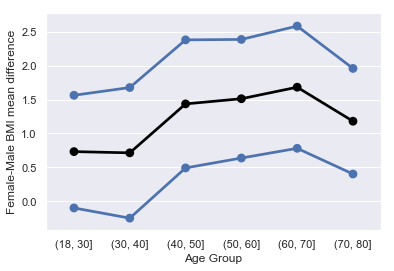

In [126]:
dataset["agegrp"] = pd.cut(dataset.RIDAGEYR,[18,30,40,50,60,70,80])
pr =  dataset.groupby(["agegrp","RIAGENDRx"]).agg({"BMXBMI":[np.mean,np.std,np.size]}).unstack()


dx_mean = dataset.groupby(["agegrp","RIAGENDRx"]).agg({"BMXBMI":[np.mean]}).unstack()
dx_mean.columns = ['Female',"Male"]

dx_std = dataset.groupby(["agegrp","RIAGENDRx"]).agg({"BMXBMI":[np.std]}).unstack()
dx_std.columns = ['Female','Male']

dx_size = dataset.groupby(["agegrp","RIAGENDRx"]).agg({"BMXBMI":[np.size]}).unstack()
dx_size.columns = ['Female','Male']

mean_diff = dx_mean.Female - dx_mean.Male
#std_diff = dx_std.Female - dx_std.Male
se = dx_std / np.sqrt(dx_size)
se_diff = np.sqrt(se.Female**2 + se.Male**2)


x = np.arange(pr.shape[0])
pp = sns.pointplot(x,mean_diff,color = 'black')
pp.set(xlabel = "Age Group", ylabel = "Female-Male BMI mean difference")
sns.pointplot(x,mean_diff - 1.96*se_diff)
sns.pointplot(x,mean_diff + 1.96*se_diff)
pp.set_xticklabels(dx_size.index)

plt.show()

In [127]:
pr

BMXBMI                                             
                mean                  std             size       
RIAGENDRx     Female       Male    Female      Male Female   Male
agegrp                                                           
(18, 30]   28.123881  27.391822  7.745893  6.649440  609.0  544.0
(30, 40]   30.325586  29.611726  8.315608  6.622412  474.0  458.0
(40, 50]   31.160643  29.724623  8.076195  6.407076  502.0  401.0
(50, 60]   30.743777  29.231486  7.575848  5.914373  470.0  454.0
(60, 70]   31.074828  29.392488  7.604514  5.933307  441.0  437.0
(70, 80]   29.138213  27.957692  6.284968  4.974855  410.0  402.0

In [135]:
dx = dataset.loc[dataset.RIAGENDRx == 'Female' ,["RIAGENDRx","BMXBMI"]].dropna()
all_cis = []

for n in 100,200,400,800:
    cis = []
    for i in range(500):
        dz = dx.sample(n)
        ci = sm.stats.DescrStatsW(dz.BMXBMI).zconfint_mean()
        cis.append(ci)
    cis = np.asarray(cis)
    mean_width = cis[:,1].mean() - cis[:,0].mean()
    print(n,mean_width)
    all_cis.append(cis)

100 3.0294656832242843
200 2.138718172970478
400 1.5212651114322462
800 1.071468881811974


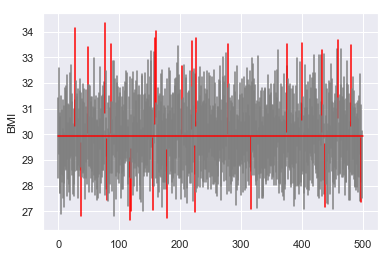

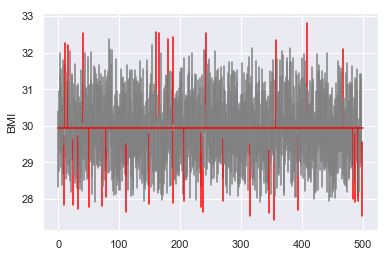

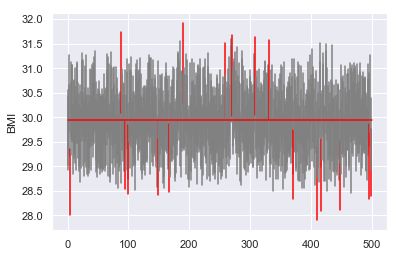

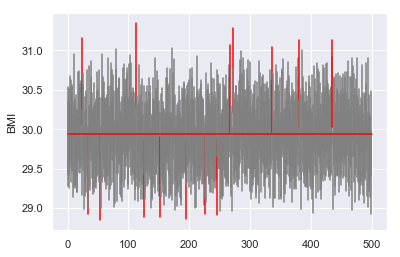

In [166]:
for i in range(4):
    ci = all_cis[i]
    mn = dx.BMXBMI.mean()
    for j,x in enumerate(ci):
        if  mn>x[0] and mn<x[1]:
            plt.plot([j,j],x,color = 'grey')
        else:
            plt.plot([j,j],x,color = 'red')
        plt.ylabel("BMI")

    plt.plot([0,500],[mn,mn],color = 'red')
    plt.show()

In [147]:
print(np.mean(ci[:,1]<mn))
print(np.mean(ci[:,0]>mn))

0.02
0.03


### Walk through hypothesis testing using NHANES

#### Hypothesis testing for one proportion

Research Question : In previous years 40% of people claim that they smoke . Do more number of smokers increase or decreased .
Now to assess this data we want to find out a significant difference in the proportion to be different from 40%

Target Population : People living in US
Parameter of Interest : Smokers and non smokers

Goal : To find out a significant difference in the proportion

$H_0$ : mu = 0.4 

$H_1$ : mu $\neq$  0.4


In [178]:
dx = dataset.SMQ020x.dropna() == 'Yes'
observed_mean = np.mean(dx)
observed_mean

0.4050655021834061

In [179]:
se = np.sqrt(0.4 *(1-0.4)/len(dx))
se

0.00647467353462031

In [183]:
test_statistic = (observed_mean - 0.4)/se
test_statistic

0.7823563854332805

In [185]:
p_value = 2*dist.norm.cdf(-np.abs(test_statistic))
p_value

0.4340051581348052

In [191]:
#Same test using statsmodels library

sm.stats.proportions_ztest(dx.sum(),len(x),0.4)
# IN this the results are slighty different because statsmodels by default uses the sample proportion instead of the null proportion

(0.672662805775994, 0.501161835318324)

In [190]:
sm.stats.binom_test(dx.sum(),len(x),0.4)
#This test assume that the distribution is binomial , we can see that in all three test out p-value is not differ by much . This is 
#expected when we have large sample size , and the proportion in not close to either 0 or 1

0.5004314022348627

### Hypothesis test for two proportions


In [200]:
dx = dataset[["SMQ020x","RIDAGEYR","RIAGENDRx"]].dropna()
dx.head()

,SMQ020x,RIDAGEYR,RIAGENDRx
0,Yes,62,Male
1,Yes,53,Male
2,Yes,78,Male
3,No,56,Female
4,No,42,Female


In [204]:
p = dx.groupby(["RIAGENDRx"]).agg({"SMQ020x": [lambda x : np.mean(x == 'Yes'),np.size]})
p.columns = ['Proportion','Total']
p

,Proportion,Total
RIAGENDRx,,
Female,0.304845,2972
Male,0.513258,2753


In [208]:
p_comb = np.mean(dx.SMQ020x == 'Yes')
va = p_comb*(1-p_comb)
se = np.sqrt(va*(1/p.Total.Female + 1/p.Total.Male))

0.01298546309757376

In [209]:
(p_comb , va , se)

(0.4050655021834061, 0.2409874411243111, 0.01298546309757376)

In [212]:
test_stat = (p.Proportion.Female - p.Proportion.Male) / se
p_value = 2*dist.norm.cdf(-np.abs(test_stat))
(test_stat , p_value)

(-16.049719603652488, 5.742288777302776e-58)

In [230]:
# Using python library

dx_females = dataset.loc[dataset["RIAGENDRx"] == 'Female','SMQ020x'].replace({'Yes':1,'No':0})
dx_females = dx_females.dropna().astype(np.int64)
dx_females.head()

3     0
4     0
5     0
7     0
12    1
Name: SMQ020x, dtype: int64

In [234]:
dx_males = dataset.loc[dataset.RIAGENDRx == 'Male' , 'SMQ020x'].replace({'Yes':1,'No':0})
dx_males = dx_males.dropna().astype(np.int64)
dx_males.head()

0    1
1    1
2    1
6    1
8    0
Name: SMQ020x, dtype: int64

In [235]:
sm.stats.ttest_ind(dx_females,dx_males)

(-16.42058555898443, 3.032088786691117e-59, 5723.0)

### Hypothesis Test Comparing Means

In [238]:
dx = dataset[["RIAGENDRx","RIDAGEYR","BPXSY1"]].dropna()
dx.head()

,RIAGENDRx,RIDAGEYR,BPXSY1
0,Male,62,128.0
1,Male,53,146.0
2,Male,78,138.0
3,Female,56,132.0
4,Female,42,100.0


In [239]:
dx = dx.loc[(dx.RIDAGEYR >= 40 ) & (dx.RIDAGEYR <=50) &(dx.RIAGENDRx == 'Male'),:]
dx.head()


,RIAGENDRx,RIDAGEYR,BPXSY1
10,Male,46,144.0
11,Male,45,116.0
20,Male,49,110.0
42,Male,42,128.0
51,Male,50,118.0


In [241]:
dx.BPXSY1.mean()

125.86698337292161

In [244]:
sm.stats.ztest(dx.BPXSY1 , value = 120)

(7.469764137102597, 8.033869113167905e-14)

In [246]:
dx = dataset[["RIAGENDRx",'RIDAGEYR','BPXSY1']].dropna()
dx.head()

,RIAGENDRx,RIDAGEYR,BPXSY1
0,Male,62,128.0
1,Male,53,146.0
2,Male,78,138.0
3,Female,56,132.0
4,Female,42,100.0


In [250]:
dx = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60),:]
dx.head()

,RIAGENDRx,RIDAGEYR,BPXSY1
1,Male,53,146.0
3,Female,56,132.0
9,Male,56,178.0
15,Female,57,134.0
19,Female,54,136.0


In [253]:
bpx_female = dx.loc[dx.RIAGENDRx == 'Female' , "BPXSY1"]
bpx_male = dx.loc[dx.RIAGENDRx == 'Male','BPXSY1']
print(bpx_female.mean() , bpx_male.mean())

127.92561983471074 129.23829787234044


In [255]:
sm.stats.ztest(bpx_female , bpx_male)

(-1.105435895556249, 0.2689707570859362)

In [256]:
sm.stats.ttest_ind(bpx_female , bpx_male)

(-1.105435895556249, 0.26925004137768577, 952.0)

In [262]:
dx = dataset[["RIAGENDRx","RIDAGEYR","BMXBMI"]].dropna()
dx["agegrp"] = pd.cut(dataset.RIDAGEYR , [18,30,40,50,60,70,80])
dx.groupby(['agegrp','RIAGENDRx']).agg({'BMXBMI':[np.std]}).unstack()
dx.head()

,RIAGENDRx,RIDAGEYR,BMXBMI,agegrp
0,Male,62,27.8,"(60, 70]"
1,Male,53,30.8,"(50, 60]"
2,Male,78,28.8,"(70, 80]"
3,Female,56,42.4,"(50, 60]"
4,Female,42,20.3,"(40, 50]"


In [264]:
for k,v in dx.groupby('agegrp'):
    bmx_female = v.loc[v.RIAGENDRx == 'Female','BMXBMI'].dropna()
    bmx_female = sm.stats.DescrStatsW(bmx_female)
    bmx_male = v.loc[v.RIAGENDRx == 'Male','BMXBMI'].dropna()
    bmx_male = sm.stats.DescrStatsW(bmx_male)
    
    print(k)
    print('Pooled : ',sm.stats.CompareMeans(bmx_female , bmx_male ).ztest_ind(usevar = 'pooled'))
    print('Unequal(Unpooled): ',sm.stats.CompareMeans(bmx_female , bmx_male).ztest_ind(usevar = 'unequal'))
    print()

(18, 30]
Pooled :  (1.7026932933643388, 0.08862548061449649)
Unequal(Unpooled):  (1.7174610823927268, 0.08589495934713022)

(30, 40]
Pooled :  (1.4378280405644916, 0.1504828511464818)
Unequal(Unpooled):  (1.4437869620833494, 0.14879891057892475)

(40, 50]
Pooled :  (2.8933761158070186, 0.003811246059501354)
Unequal(Unpooled):  (2.9678691663536725, 0.0029987194174035366)

(50, 60]
Pooled :  (3.362108779981367, 0.0007734964571391746)
Unequal(Unpooled):  (3.375494390173923, 0.0007368319423226574)

(60, 70]
Pooled :  (3.6172401442432753, 0.000297761021031936)
Unequal(Unpooled):  (3.62848309454456, 0.0002850914147149227)

(70, 80]
Pooled :  (2.926729252512258, 0.0034254694144858636)
Unequal(Unpooled):  (2.937779886769224, 0.003305716331519299)



### Paired Data

In [266]:
dx = dataset[["BPXSY1" , "BPXSY2"]].dropna()
mean_diff = dx.BPXSY1 - dx.BPXSY2
print(mean_diff.mean())
sm.stats.ztest(mean_diff)

0.6749860309182343


(9.800634425497911, 1.1188070930963587e-22)

In [275]:
dx = dataset[["RIAGENDRx","BPXSY1","BPXSY2",'RIDAGEYR']].dropna()
dx["agegrp"] = pd.cut(dataset.RIDAGEYR , [18,30,40,50,60,70,80])
for k,g in dx.groupby(['RIAGENDRx',"agegrp"]):
    db = g.BPXSY1 - g.BPXSY2
    print(k,db.mean(),db.size,sm.stats.ztest(db.values , value = 10))
    

('Female', Interval(18, 30, closed='right')) 0.13708260105448156 569 (-54.76813654969278, 0.0)
('Female', Interval(30, 40, closed='right')) 0.6713615023474179 426 (-45.95665258829859, 0.0)
('Female', Interval(40, 50, closed='right')) 0.5970149253731343 469 (-41.01396330311383, 0.0)
('Female', Interval(50, 60, closed='right')) 0.7685393258426966 445 (-37.26474755222869, 6.114146911342618e-304)
('Female', Interval(60, 70, closed='right')) 0.8787878787878788 396 (-32.20132096222309, 1.6913370159731827e-227)
('Female', Interval(70, 80, closed='right')) 1.4512820512820512 390 (-30.287015409477906, 1.699535280212017e-201)
('Male', Interval(18, 30, closed='right')) 0.00390625 512 (-50.146748517764415, 0.0)
('Male', Interval(30, 40, closed='right')) 0.46296296296296297 432 (-40.070163724752064, 0.0)
('Male', Interval(40, 50, closed='right')) 0.17894736842105263 380 (-39.52517738740925, 0.0)
('Male', Interval(50, 60, closed='right')) 0.3691588785046729 428 (-37.54441546360662, 1.73779699693308e

In [277]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60),:]
for n in 100,200,400,800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _ , p = sm.stats.ztest(db.values,value = 0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv <= 0.05).mean())    

0.21
0.314
0.672
1.0


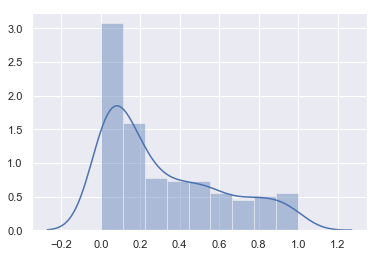

In [278]:
sns.distplot(all_p[0])

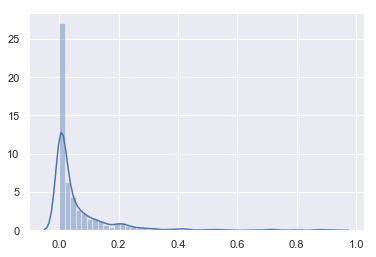

In [279]:
sns.distplot(all_p[2])